### TRANING BASE MODELS

## Training DenseNet without weighted losses

In [57]:
# Install necessary libraries (if not already installed)
!pip install torch torchvision
!pip install plotly

# Import necessary libraries
import pandas as pd
import cv2
from tqdm.auto import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import os

In [58]:
img_path = "Data/images/"
TRAIN_PATH = "Data/train.csv"
TEST_PATH = "Data/test.csv"

train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

### Model traning Standard Loss

In [59]:
train_data

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [65]:
# Constructing the img_path using the base path, image_id, and .jpg extension
train_data['img_path'] = train_data['image_id'].apply(lambda x: f"data/images/{x}.jpg")
# Check if the first image path in the DataFrame exists
print(os.path.exists(train_data['img_path'][0]))  

True


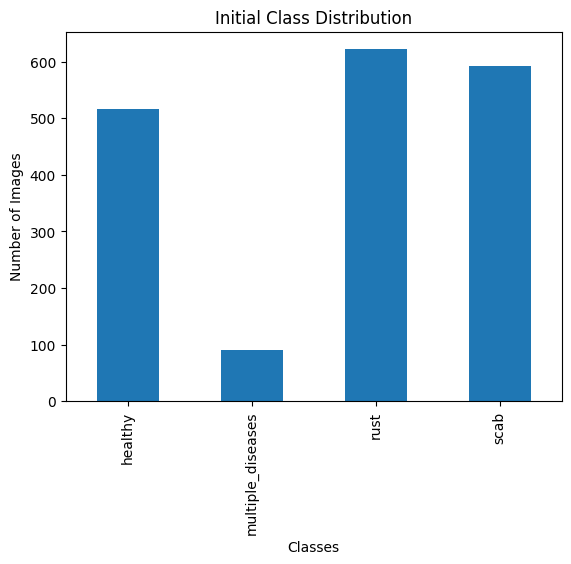

In [66]:
initial_distribution = train_data[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()
initial_distribution.plot(kind='bar')
plt.title('Initial Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [67]:
labels = train_data[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)

X_train, X_Val, y_train, y_val = train_test_split(
    train_data['image_id'],  # or df.drop(['label'], axis=1) for features only
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


X_Val, X_test, y_val, y_test = train_test_split(
    X_Val,
    y_val,
    test_size=0.27,  # Split the validation set in half
    random_state=42,
    stratify=y_val
)



In [68]:
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_Val)}")
print(f"Test set size: {len(X_test)}")


Train set size: 1456
Validation set size: 266
Test set size: 99


Training Set Distribution:
 rust                 0.341346
scab                 0.324863
healthy              0.283654
multiple_diseases    0.050137
Name: proportion, dtype: float64
Test Set Distribution:
 rust                 0.342105
scab                 0.327068
healthy              0.281955
multiple_diseases    0.048872
Name: proportion, dtype: float64
Test Set Distribution:
 rust                 0.343434
scab                 0.323232
healthy              0.282828
multiple_diseases    0.050505
Name: proportion, dtype: float64


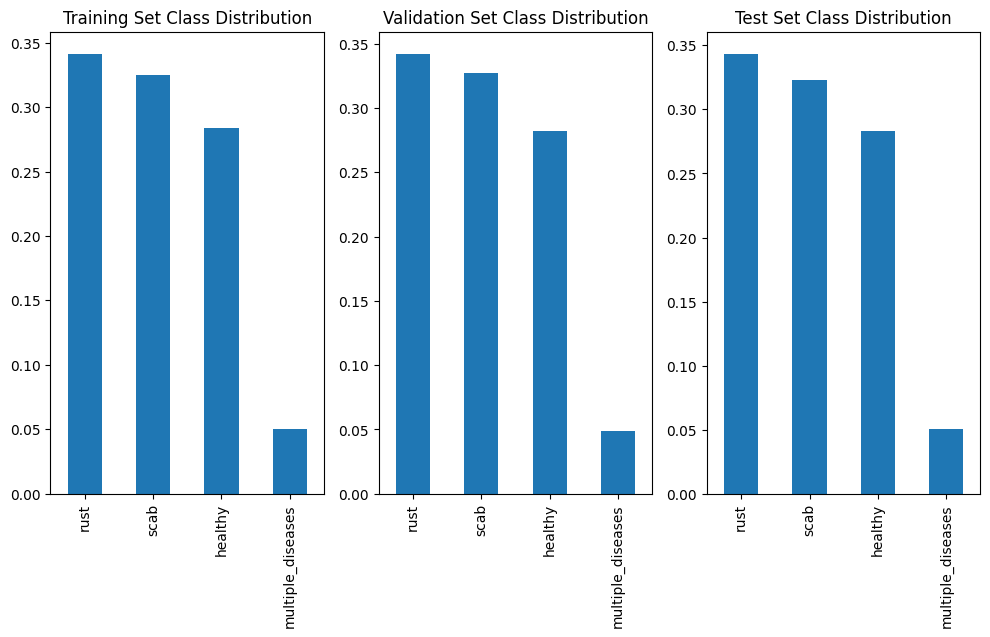

In [69]:
train_distribution = y_train.value_counts(normalize=True)
print("Training Set Distribution:\n", train_distribution)

# Check the distribution in the test set
validation_distribution = y_val.value_counts(normalize=True)
print("Test Set Distribution:\n", validation_distribution)

test_distribution = y_test.value_counts(normalize=True)
print("Test Set Distribution:\n", test_distribution)

# Plot the distributions
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

train_distribution.plot(kind='bar', ax=ax[0], title='Training Set Class Distribution')
validation_distribution.plot(kind='bar', ax=ax[1], title='Validation Set Class Distribution')
test_distribution.plot(kind='bar', ax=ax[2], title='Test Set Class Distribution')



plt.show()

In [75]:

# Define the custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, df, image_ids, labels, transform=None):
        self.df = df
        self.image_ids = image_ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids.iloc[idx]
        img_path = self.df.loc[self.df['image_id'] == img_id, 'img_path'].values[0]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels.iloc[idx]
        return image, torch.tensor(label, dtype=torch.long)

train_transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(15),  # Randomly rotate images within a specified degree range
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Randomly jitter brightness, contrast, and saturation
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Randomly apply Gaussian blur
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

valid_transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 224x224 for validation
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

test_transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the images to match the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# DataLoader setup
# Mapping string labels to integers
label_mapping = {'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}
numerical_y_train = y_train.map(label_mapping)
numerical_y_val = y_val.map(label_mapping)
numerical_y_test = y_test.map(label_mapping)

# Creating dataset instances
train_dataset = CustomImageDataset(train_data, X_train, numerical_y_train, transform=train_transformations)
valid_dataset = CustomImageDataset(train_data, X_Val, numerical_y_val, transform=valid_transformations)
test_dataset = CustomImageDataset(train_data, X_test, numerical_y_test, transform=test_transformations)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


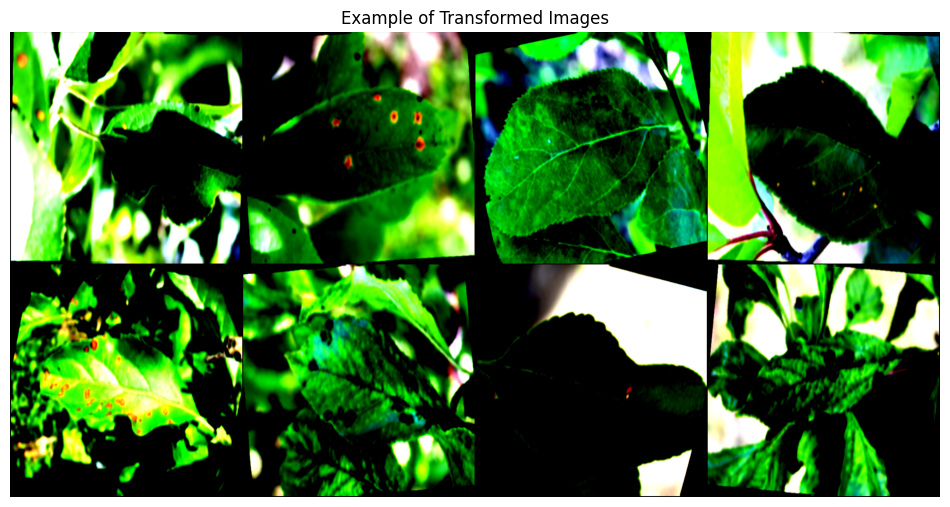

Corresponding labels: tensor([2, 2, 3, 2, 2, 3, 2, 3])


In [76]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_transformed_images(dataloader, num_images=8):
    images, labels = next(iter(dataloader))
    # Create a grid of images
    grid = make_grid(images[:num_images], nrow=4)  # Adjust nrow according to your preference
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))  # because images are [C, H, W]
    plt.title('Example of Transformed Images')
    plt.axis('off')
    plt.show()
    print("Corresponding labels:", labels[:num_images])

show_transformed_images(train_loader)

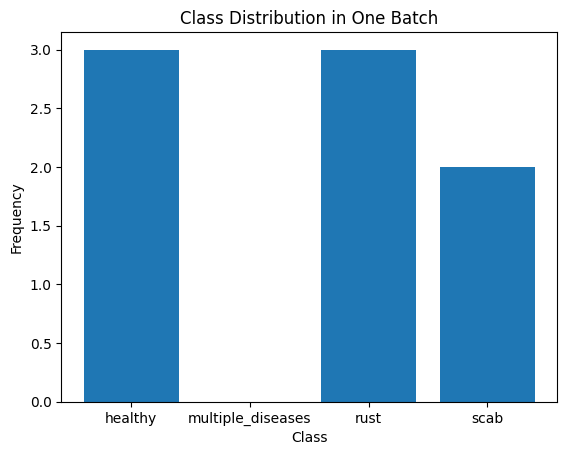

In [77]:
def analyze_class_distribution(dataloader):
    label_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for images, labels in dataloader:
        for label in labels:
            label_counts[label.item()] += 1
        break  # Only process the first batch for demonstration

    # Visualizing the distribution
    labels, counts = zip(*label_counts.items())
    plt.bar(labels, counts, tick_label=[k for k in label_mapping.keys()])
    plt.title('Class Distribution in One Batch')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

analyze_class_distribution(train_loader)

In [78]:
print("lenght of the train_loader",len(train_loader))
print("lenght of the valid_loader",len(valid_loader))
print("lenght of the test_loader",len(test_loader))

lenght of the train_loader 182
lenght of the valid_loader 34
lenght of the test_loader 13


In [ ]:
# Install necessary libraries (if not already installed)
!pip install torch torchvision
!pip install plotly

# Import necessary libraries
import pandas as pd
import cv2
from tqdm.auto import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim



# Set device
if torch.backends.mps.is_available():
    device = "mps"  
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


# Define the model
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=4):  # Adjust num_classes as per your dataset
        super(CustomDenseNet, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomDenseNet(num_classes=4).to(device)


# Define the validation function
def validate_model(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() 
            _, predicted = torch.max(outputs.data, -1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(valid_loader)
    accuracy = correct / total
    return avg_loss, accuracy


# Define the training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    print(f"Starting training for {num_epochs} epochs.")
    history = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': []
    }
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}', leave=True)
        
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed. Average Loss: {average_loss}")

        valid_loss, valid_accuracy = validate_model(model, valid_loader, criterion, device)
        history['train_loss'].append(average_loss)
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_accuracy)
        print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
    
    print("Training completed.")
    return history

# Main script
if __name__ == '__main__':
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    model.to(device)
    history = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, device=device)


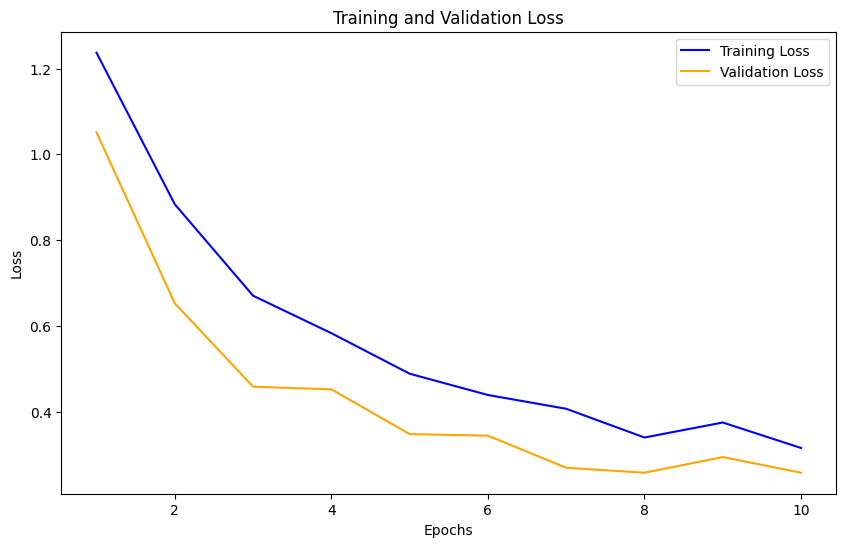

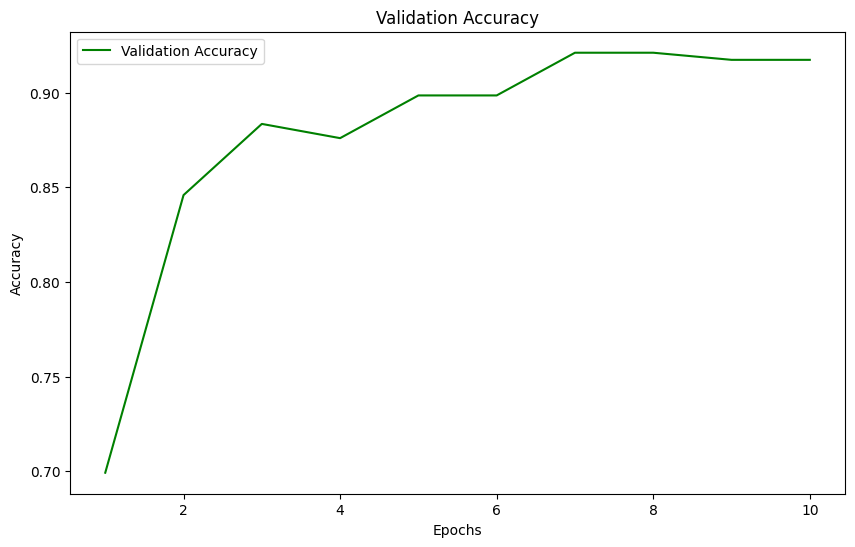

In [85]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot both training and validation loss on the same plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history['valid_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    # Plot validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['valid_accuracy'], label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

# Call the plotting function with the history
plot_training_history(history)

In [87]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_predictions))

    return all_predictions, all_labels

# Assuming model, valid_loader and device are already defined
# all_prediction, all_lable = evaluate_model(model, test_loader, device)

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(actuals, predictions, classes):
    cm = confusion_matrix(actuals, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

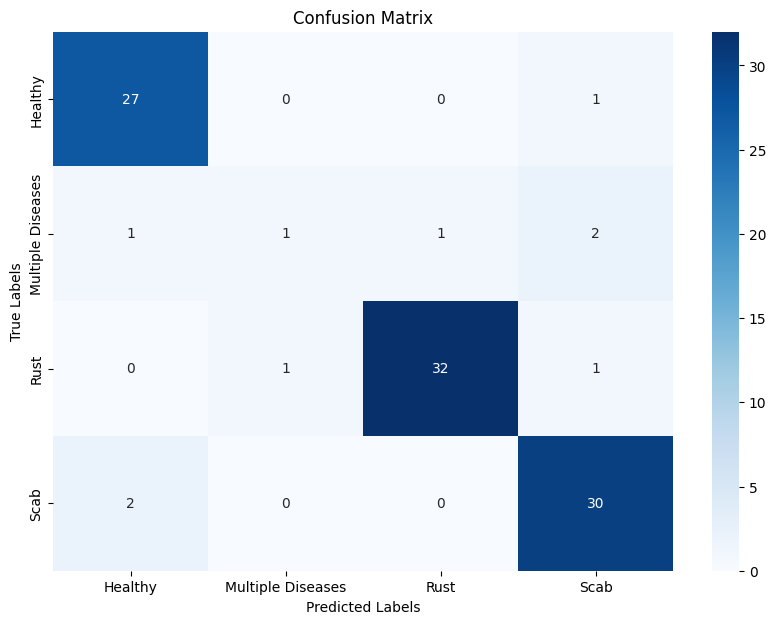

In [ ]:


# Assuming you have actuals and predictions arrays available from the evaluation
plot_confusion_matrix(all_lable, all_prediction, classes=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])

### 

### Saving the model

In [149]:
torch.save(model.state_dict(), 'model_state_dict_v2.pth')

### Loading the model and Predicitng on the Actually test set

In [78]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm  # Import tqdm for progress bar

class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=4):  # Adjust num_classes as per your dataset
        super(CustomDenseNet, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomDenseNet(num_classes=4).to(device)

# Load the model checkpoint
# if torch.backends.mps.is_available() == "True":
#     device = "mps"
# elif torch.cuda.is_available():
#     device = "cuda"
# else:
#     device = "cpu"

device = "mps"

print(f"Using device: {device}")    

model = CustomDenseNet(num_classes=4).to(device)
print(model)
model.load_state_dict(torch.load('model_state_dict.pth'))
model.eval()

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: mps
CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_s

/var/folders/4j/f9p0tjqj1ql3bytxkr213dn40000gn/T/ipykernel_84265/264784464.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_state

CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

### Evaluating the Test Data

In [80]:
# Assuming `test_data` from a DataFrame that includes paths and potential 'image_id'
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define test transformations with the correct resizing if it's 448x448
test_transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 224x224 for validation
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Load test images with corrected paths
test_dataset = TestDataset(test_data['img_path'].values, transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Rest of the code remains largely unchanged

# Prediction function
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Predicting", unit="batch"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            predictions.extend(probs.cpu().numpy())  # Move to CPU and convert to NumPy for easier handling
    return predictions

# Run predictions with progress tracking
predictions = predict(model, test_loader, device)

# Create a DataFrame for submission
sub = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
sub['image_id'] = test_data['image_id']  # Assuming 'image_id' column exists in test_data
sub = sub[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]  # Arrange columns as required
print(sub.head())

Predicting:   0%|          | 0/228 [00:00<?, ?batch/s]

  image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.000244           0.001591  0.998146  0.000018
1   Test_1  0.009420           0.062232  0.925367  0.002981
2   Test_2  0.011725           0.002070  0.000265  0.985940
3   Test_3  0.999289           0.000098  0.000492  0.000121
4   Test_4  0.000352           0.001514  0.998045  0.000089


## Traning DenseNet with weighted Loss

In [81]:
from sklearn.utils.class_weight import compute_class_weight

# labels should be a 1D array of all label indices for the dataset
labels = train_data[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(class_weights_tensor)

tensor([0.8823, 5.0027, 0.7319, 0.7690], device='mps:0')


In [ ]:
# Define the training function
def train_model_weighted_loss(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    print(f"Starting training for {num_epochs} epochs.")
    history = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': []
    }
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}', leave=True)
        
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed. Average Loss: {average_loss}")

        valid_loss, valid_accuracy = validate_model(model, valid_loader, criterion, device)
        history['train_loss'].append(average_loss)
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_accuracy)
        print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
    
    print("Training completed.")
    return history

# Main script
if __name__ == '__main__':
    model = CustomDenseNet(num_classes=4).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    model.to(device)
    history = train_model_weighted_loss(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, device=device)

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for 10 epochs.


Epoch 1:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 1 completed. Average Loss: 1.230256831580466
Validation Loss: 1.0002, Validation Accuracy: 0.7068


Epoch 2:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 2 completed. Average Loss: 0.8510106476126137
Validation Loss: 0.6470, Validation Accuracy: 0.8045


Epoch 3:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 3 completed. Average Loss: 0.6624432673657333
Validation Loss: 0.4844, Validation Accuracy: 0.8647


Epoch 4:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 4 completed. Average Loss: 0.528110642354567
Validation Loss: 0.3586, Validation Accuracy: 0.8872


Epoch 5:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 5 completed. Average Loss: 0.46408326850160136
Validation Loss: 0.3279, Validation Accuracy: 0.8835


Epoch 6:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 6 completed. Average Loss: 0.41461921315435524
Validation Loss: 0.2621, Validation Accuracy: 0.9173


Epoch 7:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 7 completed. Average Loss: 0.3921354395838884
Validation Loss: 0.2471, Validation Accuracy: 0.9398


Epoch 8:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 8 completed. Average Loss: 0.3364153697186119
Validation Loss: 0.2451, Validation Accuracy: 0.9248


Epoch 9:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 9 completed. Average Loss: 0.35911625531594177
Validation Loss: 0.2142, Validation Accuracy: 0.9398


Epoch 10:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 10 completed. Average Loss: 0.2992438376973291
Validation Loss: 0.2143, Validation Accuracy: 0.9436
Training completed.


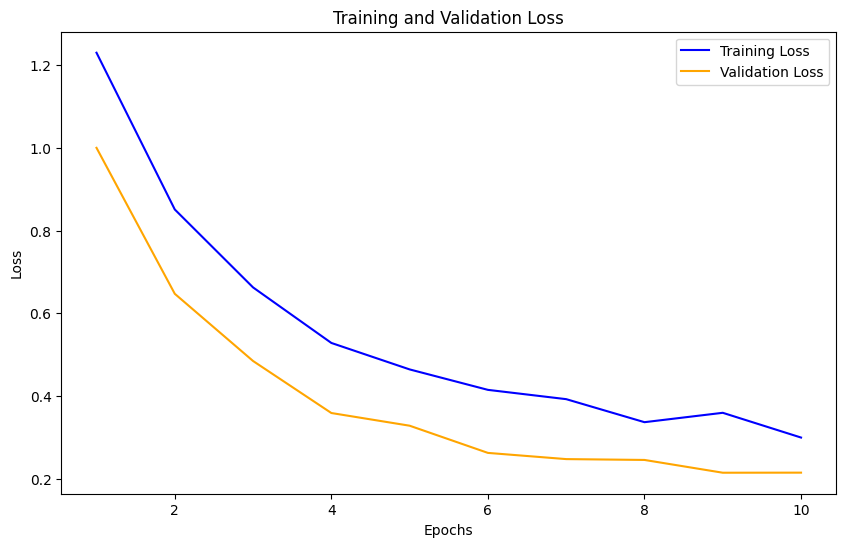

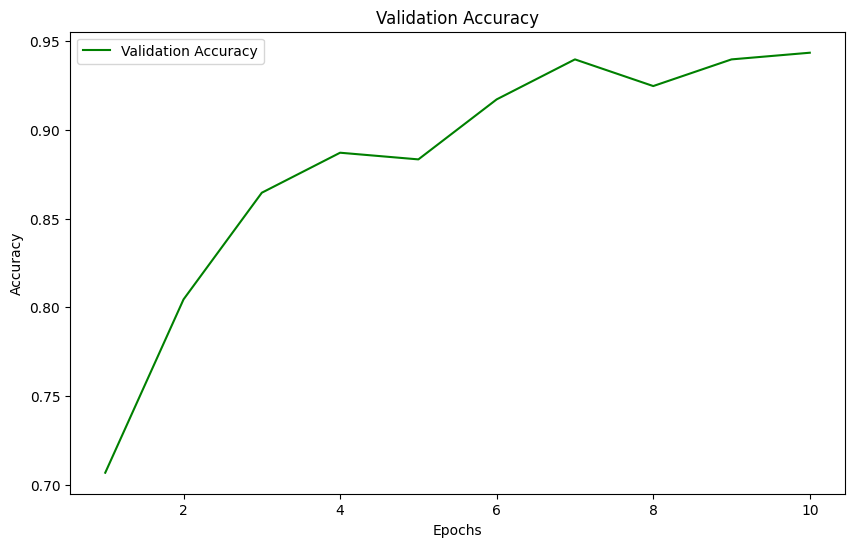

In [157]:
plot_training_history(history)

In [158]:
all_prediction, all_lable = evaluate_model(model, test_loader, device)

Precision: 0.8602
Recall: 0.8623
F1 Score: 0.8601

Classification Report:

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       0.60      0.60      0.60         5
           2       1.00      0.91      0.95        34
           3       0.94      0.94      0.94        32

    accuracy                           0.93        99
   macro avg       0.86      0.86      0.86        99
weighted avg       0.93      0.93      0.93        99



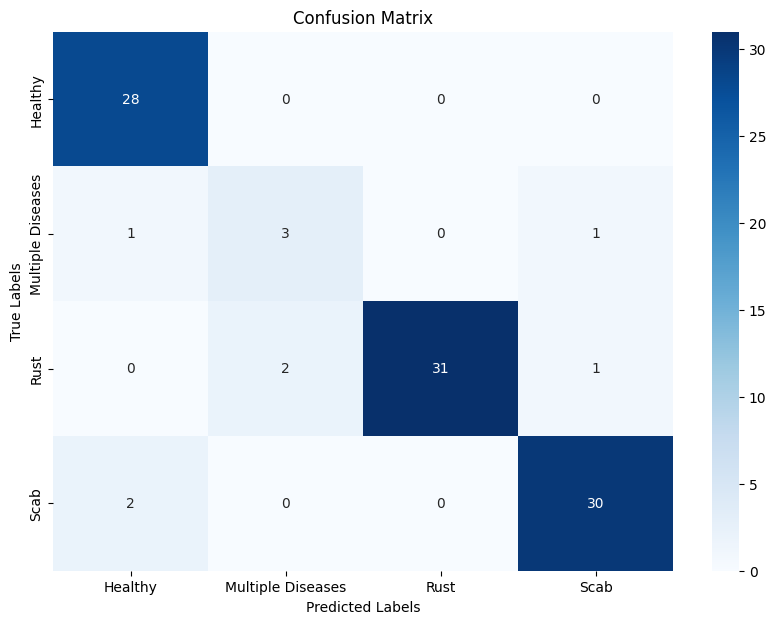

In [159]:
plot_confusion_matrix(all_lable, all_prediction, classes=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])

### Model Performance Comparison: Before and After Weighted Loss Implementation

#### Metrics After Implementing Weighted Loss:
- **Precision**: 0.8602
- **Recall**: 0.8623
- **F1 Score**: 0.8601

**Classification Report (After Weighted Loss):**
| Class              | Precision | Recall | F1 Score | Support |
|--------------------|-----------|--------|----------|---------|
| Healthy            | 0.90      | 1.00   | 0.95     | 28      |
| Multiple Diseases  | 0.60      | 0.60   | 0.60     | 5       |
| Rust               | 1.00      | 0.91   | 0.95     | 34      |
| Scab               | 0.94      | 0.94   | 0.94     | 32      |
| **Accuracy**       |           |        | 0.93     | 99      |
| **Macro Avg**      | 0.86      | 0.86   | 0.86     | 99      |
| **Weighted Avg**   | 0.93      | 0.93   | 0.93     | 99      |

#### Metrics Before Implementing Weighted Loss:
- **Precision**: 0.8130
- **Recall**: 0.7607
- **F1 Score**: 0.7703

**Classification Report (Before Weighted Loss):**
| Class              | Precision | Recall | F1 Score | Support |
|--------------------|-----------|--------|----------|---------|
| Healthy            | 0.90      | 0.96   | 0.93     | 28      |
| Multiple Diseases  | 0.50      | 0.20   | 0.29     | 5       |
| Rust               | 0.97      | 0.94   | 0.96     | 34      |
| Scab               | 0.88      | 0.94   | 0.91     | 32      |
| **Accuracy**       |           |        | 0.91     | 99      |
| **Macro Avg**      | 0.81      | 0.76   | 0.77     | 99      |
| **Weighted Avg**   | 0.90      | 0.91   | 0.90     | 99      |

### Analysis
Implementing weighted loss significantly improved the precision, recall, and F1 score for the 'Multiple Diseases' class, elevating overall model accuracy and balancing performance across classes. The macro and weighted averages show a clear uplift, highlighting the effectiveness of addressing class imbalance in training.

In [160]:
torch.save(model.state_dict(), 'model_state_dict_v3.pth')

In [91]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm  # Import tqdm for progress bar

class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=4):  # Adjust num_classes as per your dataset
        super(CustomDenseNet, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomDenseNet(num_classes=4).to(device)

# Load the model checkpoint
# if torch.backends.mps.is_available() == "True":
#     device = "mps"
# elif torch.cuda.is_available():
#     device = "cuda"
# else:
#     device = "cpu"

device = "mps"

print(f"Using device: {device}")    

model = CustomDenseNet(num_classes=4).to(device)
print(model)
model.load_state_dict(torch.load('model_state_dict_v3.pth'))
model.eval()

/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mynewenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: mps
CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_s

/var/folders/4j/f9p0tjqj1ql3bytxkr213dn40000gn/T/ipykernel_5183/3121815602.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_state

CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [161]:
# Assuming `test_data` from a DataFrame that includes paths and potential 'image_id'
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define test transformations with the correct resizing if it's 448x448
test_transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 224x224 for validation
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Load test images with corrected paths
test_dataset = TestDataset(test_data['img_path'].values, transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Rest of the code remains largely unchanged

# Prediction function
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Predicting", unit="batch"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            predictions.extend(probs.cpu().numpy())  # Move to CPU and convert to NumPy for easier handling
    return predictions

# Run predictions with progress tracking
predictions = predict(model, test_loader, device)

# Create a DataFrame for submission
sub = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
sub['image_id'] = test_data['image_id']  # Assuming 'image_id' column exists in test_data
sub = sub[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]  # Arrange columns as required
print(sub.head())

Predicting:   0%|          | 0/228 [00:00<?, ?batch/s]

  image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.002238           0.025991  0.971648  0.000123
1   Test_1  0.034468           0.201440  0.753512  0.010580
2   Test_2  0.008344           0.004730  0.000323  0.986604
3   Test_3  0.997062           0.000231  0.002291  0.000417
4   Test_4  0.001212           0.012212  0.985433  0.001143


## Train EfficientNet with Weighted Loss:

In [102]:
def custom_efficientnet(num_classes, pretrained=True):
    # Load a pre-trained EfficientNet
    model = models.efficientnet_b7(pretrained=pretrained)
    
    # Replace the classifier
    num_features = model.classifier[1].in_features  # Get the input feature count of the classifier
    model.classifier[1] = nn.Linear(num_features, num_classes)  # Replace the classifier with a new one
    
    return model

In [ ]:
# Define the training function
def train_model_weighted_loss(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    print(f"Starting training for {num_epochs} epochs.")
    history = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': []
    }
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}', leave=True)
        
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed. Average Loss: {average_loss}")

        valid_loss, valid_accuracy = validate_model(model, valid_loader, criterion, device)
        history['train_loss'].append(average_loss)
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_accuracy)
        print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
    
    print("Training completed.")
    return history

# Main script
if __name__ == '__main__':
    EfficientNetmodel = custom_efficientnet(num_classes=4,pretrained = True).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  
    optimizer = optim.Adam(model.parameters(), lr=0.000001)

    model.to(device)
    print("device",device)
    history = train_model_weighted_loss(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, device=device)
  
    torch.save(model.state_dict(), 'model_state_dict_WEIGHTED_EFFICENTNET.pth')  

device mps
Starting training for 10 epochs.


Epoch 1:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 1 completed. Average Loss: 0.38816073299948495
Validation Loss: 0.1687, Validation Accuracy: 0.9361


Epoch 2:   0%|          | 0/182 [00:00<?, ?it/s]

KeyboardInterrupt: 

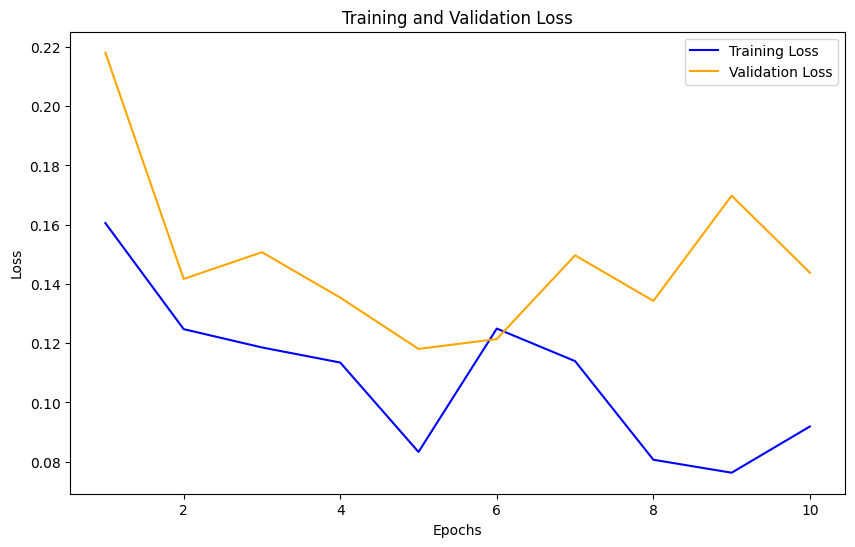

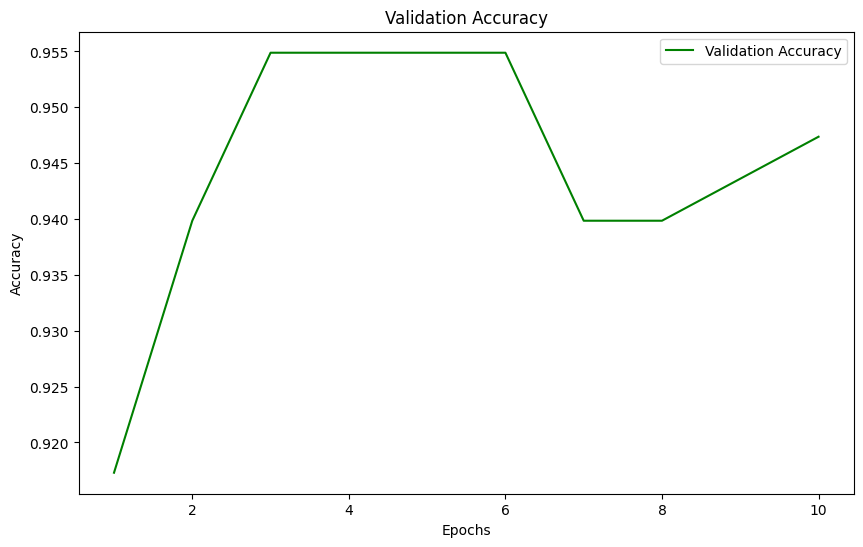

In [101]:
plot_training_history(history)

In [89]:
all_prediction, all_lable = evaluate_model(model, test_loader, device)

Precision: 0.8109
Recall: 0.8467
F1 Score: 0.8206

Classification Report:

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       0.38      0.60      0.46         5
           2       1.00      0.91      0.95        34
           3       0.97      0.88      0.92        32

    accuracy                           0.91        99
   macro avg       0.81      0.85      0.82        99
weighted avg       0.93      0.91      0.92        99



### Stacking Ensemble

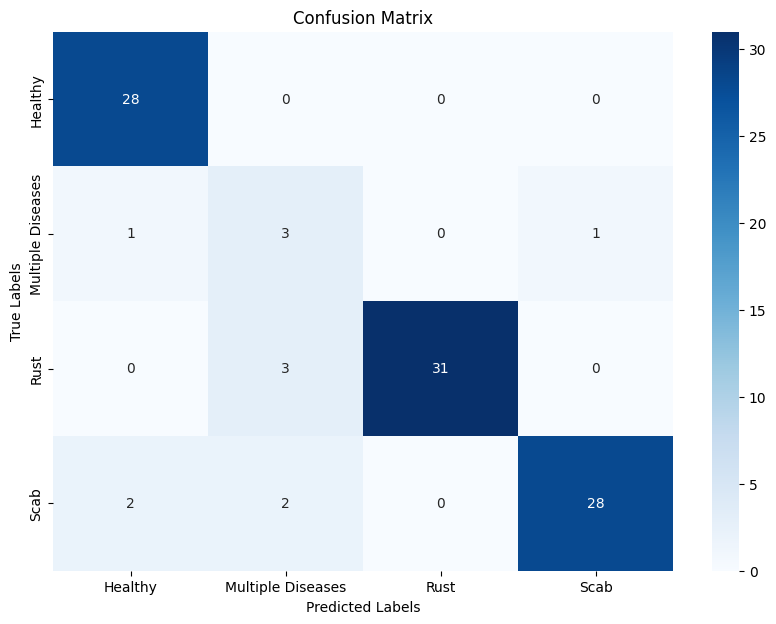

In [90]:
plot_confusion_matrix(all_lable, all_prediction, classes=['Healthy', 'Multiple Diseases', 'Rust', 'Scab'])